In [50]:
import torch, cv2, os, numpy as np
from torch.utils.data import Dataset, DataLoader
from skimage.color import rgb2lab, lab2rgb

print("CUDA available:", torch.cuda.is_available())


CUDA available: True


## Input Video Acquisition
In this step, a real-world video is downloaded from an online public source.
This video will later be converted into a 30-second black-and-white input.


In [51]:
!wget -O video.mp4 https://media.w3.org/2010/05/sintel/trailer.mp4


--2025-12-22 17:10:22--  https://media.w3.org/2010/05/sintel/trailer.mp4
Resolving media.w3.org (media.w3.org)... 104.18.22.19, 104.18.23.19, 2606:4700::6812:1713, ...
Connecting to media.w3.org (media.w3.org)|104.18.22.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4372373 (4.2M) [video/mp4]
Saving to: ‘video.mp4’

video.mp4           100%[===================>]   4.17M  --.-KB/s    in 0.05s   

2025-12-22 17:10:23 (92.4 MB/s) - ‘video.mp4’ saved [4372373/4372373]



In [52]:
!ls


bw_30sec.mp4  colorized_30sec.mp4  frames	  sample_data
bw_video.mp4  drive		   report_frames  video.mp4


## Black & White Video Preparation
The downloaded video is converted to grayscale and trimmed to exactly 30 seconds
to meet the project input requirements.


In [53]:
!ffmpeg -i video.mp4 -vf format=gray bw_video.mp4
!ffmpeg -i bw_video.mp4 -t 30 bw_30sec.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [54]:
from IPython.display import Video
Video("bw_30sec.mp4")


## Frame Extraction
Video frames are extracted at a low frame rate (1 frame per second) to create
a small and memory-efficient training dataset.


In [55]:
!mkdir frames
!ffmpeg -i video.mp4 -vf fps=1 frames/frame_%03d.jpg


mkdir: cannot create directory ‘frames’: File exists
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable

## Dataset Construction
This dataset class loads extracted frames, converts them to LAB color space,
and prepares the luminance and chrominance components for training.


In [56]:
class FrameDataset(Dataset):
    def __init__(self, frame_dir):
        self.frames = [os.path.join(frame_dir, f) for f in os.listdir(frame_dir)]

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        img = cv2.imread(self.frames[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (96,96))

        lab = rgb2lab(img).astype("float32")
        L = lab[:,:,0]/50.0 - 1.0
        ab = lab[:,:,1:]/128.0

        return (
            torch.from_numpy(L).unsqueeze(0),
            torch.from_numpy(ab).permute(2,0,1)
        )


## Model Architecture
A convolutional neural network (CNN) is defined to predict chrominance channels
from grayscale input frames.


In [57]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 2, 3, 1, 1), nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


## Model Training
The model is trained on a small set of real-world frames to validate the
colorization pipeline under limited computational resources.


In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = FrameDataset("frames")
loader = DataLoader(dataset, batch_size=1, shuffle=True)

model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

for epoch in range(2):
    for L, ab in loader:
        L, ab = L.to(device), ab.to(device)
        loss = criterion(model(L), ab)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} finished")


Epoch 1 finished
Epoch 2 finished


## Video Colorization
The trained model is applied frame-by-frame to the 30-second black-and-white video
to generate the final colorized video output.


In [59]:
def colorize_video(model, input_video, output_video):
    cap = cv2.VideoCapture(input_video)
    out = cv2.VideoWriter(
        output_video,
        cv2.VideoWriter_fourcc(*'mp4v'),
        30,
        (96,96)
    )

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (96,96))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        L = gray/255.0*2 - 1
        with torch.no_grad():
            ab = model(
                torch.tensor(L, dtype=torch.float32)
                .unsqueeze(0)
                .unsqueeze(0)
                .to(device)
            )[0].cpu().permute(1,2,0).numpy() * 128


        lab = np.dstack([(L+1)*50, ab])
        rgb = (lab2rgb(lab)*255).astype("uint8")

        out.write(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))

    cap.release()
    out.release()


In [60]:
colorize_video(model, "bw_30sec.mp4", "colorized_30sec.mp4")
Video("colorized_30sec.mp4")


/tmp/ipython-input-580539133.py:28: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb = (lab2rgb(lab)*255).astype("uint8")
/tmp/ipython-input-580539133.py:28: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  rgb = (lab2rgb(lab)*255).astype("uint8")
/tmp/ipython-input-580539133.py:28: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  rgb = (lab2rgb(lab)*255).astype("uint8")


## Results Visualization
This step visualizes the same video frame before and after colorization
to qualitatively evaluate the model output.


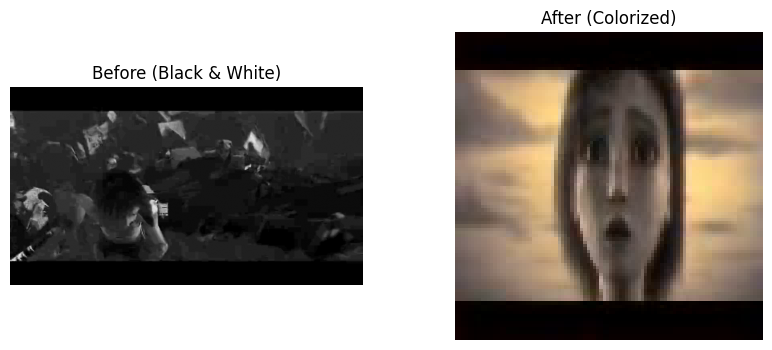

In [61]:
import matplotlib.pyplot as plt
import cv2

TIME_SEC = 22
TIME_MS = TIME_SEC * 1000

cap = cv2.VideoCapture("bw_30sec.mp4")
cap.set(cv2.CAP_PROP_POS_MSEC, TIME_MS)
ret, bw_frame = cap.read()
cap.release()

bw_display = cv2.cvtColor(bw_frame, cv2.COLOR_BGR2GRAY)

cap = cv2.VideoCapture("colorized_30sec.mp4")
cap.set(cv2.CAP_PROP_POS_MSEC, TIME_MS)
ret, color_frame = cap.read()
cap.release()

color_display = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Before (Black & White)")
plt.imshow(bw_display, cmap='gray')
plt.axis("off")

plt.subplot(1,2,2)
plt.title("After (Colorized)")
plt.imshow(color_display)
plt.axis("off")

plt.show()


In [62]:
import cv2
import numpy as np
import os

def extract_best_frames(video_path, out_dir, num_frames=5):
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)

    frames = []
    times = []

    fps = cap.get(cv2.CAP_PROP_FPS)

    i = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        score = np.var(gray)

        frames.append((score, frame))
        times.append(i / fps)
        i += 1

    cap.release()

    frames_sorted = sorted(enumerate(frames), key=lambda x: x[1][0], reverse=True)
    selected = frames_sorted[:num_frames]

    timestamps = []

    for idx, (score, frame) in selected:
        t = times[idx]
        timestamps.append(t)
        cv2.imwrite(f"{out_dir}/frame_{len(timestamps)}.jpg", frame)

    return timestamps


In [63]:
timestamps = extract_best_frames(
    "bw_30sec.mp4",
    "report_frames/bw",
    num_frames=5
)

cap = cv2.VideoCapture("colorized_30sec.mp4")
os.makedirs("report_frames/colorized", exist_ok=True)

for i, t in enumerate(timestamps):
    cap.set(cv2.CAP_PROP_POS_MSEC, int(t * 1000))
    ret, frame = cap.read()
    if ret:
        cv2.imwrite(f"report_frames/colorized/frame_{i+1}.jpg", frame)

cap.release()


#choose the best 5 frames


In [64]:
import cv2
import numpy as np
import os

def extract_best_frame_indices(video_path, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    scores = []

    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        score = np.var(gray)
        scores.append((score, idx))
        idx += 1

    cap.release()

    scores.sort(reverse=True, key=lambda x: x[0])
    return [idx for _, idx in scores[:num_frames]]


In [65]:
def save_frames_by_index(video_path, frame_indices, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)

    for i, idx in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            cv2.imwrite(f"{out_dir}/frame_{i+1}.jpg", frame)

    cap.release()


In [66]:
# best frame in BW
best_indices = extract_best_frame_indices("bw_30sec.mp4", num_frames=5)

save_frames_by_index("bw_30sec.mp4", best_indices, "report_frames/bw")

save_frames_by_index("colorized_30sec.mp4", best_indices, "report_frames/colorized")
